In [1]:
import tensorcircuit as tc
from jax import numpy as jnp
import optax
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import cotengra as ctg
from typing import Union
import time
import odbo
from IPython.display import clear_output

K = tc.set_backend("jax")
tc.set_dtype("complex128")
dtype = torch.float64

# cotengra package to speed up the calculation
opt_ctg = ctg.ReusableHyperOptimizer(
    methods=["greedy", "kahypar"],
    parallel=True,
    minimize="combo",
    max_time=20,
    max_repeats=128,
    progbar=True,
)

tc.set_contractor("custom", optimizer=opt_ctg, preprocessing=True)

nlayers = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acqfn = "ucb"

2025-02-20 11:37:45.146448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740073065.296006   13419 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740073065.347725   13419 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/ziqguo/conda/envs/tc/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/ziqguo/conda/envs/tc/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper o

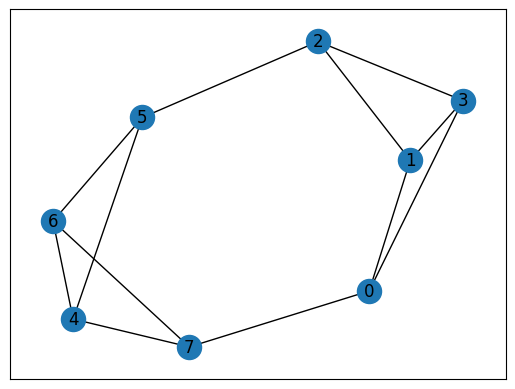

In [2]:
# a graph instance
graph_dict = {
    0: {1: {"weight": 1.0}, 7: {"weight": 1.0}, 3: {"weight": 1.0}},
    1: {0: {"weight": 1.0}, 2: {"weight": 1.0}, 3: {"weight": 1.0}},
    2: {1: {"weight": 1.0}, 3: {"weight": 1.0}, 5: {"weight": 1.0}},
    3: {1: {"weight": 1.0}, 2: {"weight": 1.0}, 0: {"weight": 1.0}},
    4: {7: {"weight": 1.0}, 6: {"weight": 1.0}, 5: {"weight": 1.0}},
    5: {6: {"weight": 1.0}, 4: {"weight": 1.0}, 2: {"weight": 1.0}},
    6: {7: {"weight": 1.0}, 4: {"weight": 1.0}, 5: {"weight": 1.0}},
    7: {4: {"weight": 1.0}, 6: {"weight": 1.0}, 0: {"weight": 1.0}},
}

graph = nx.to_networkx_graph(graph_dict)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True, pos=pos)
ax = plt.gca()
ax.set_facecolor("w")

bit string: ['01010101', '10101010'] 
max cut: 10.0


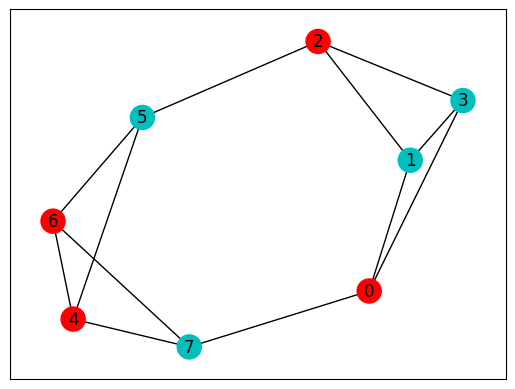

In [3]:
def classical_solver(graph):
    num_nodes = len(graph)
    max_cut = [0]
    best_case = [0]  # "01" series with max cut
    for i in range(2**num_nodes):
        case = f"{bin(i)[2:]:0>{num_nodes}}"
        cat1, cat2 = [], []
        for j in range(num_nodes):
            if str(case)[j] == "0":
                cat1.append(j)
            else:
                cat2.append(j)

        # calculate the cost function
        cost = 0
        for node1 in cat1:
            for node2 in cat2:
                if graph[node1].get(node2):
                    cost += graph[node1][node2]["weight"]
        cost = round(cost, 4)  # elimate minor error
        if max_cut[-1] <= cost:
            max_cut.append(cost)
            best_case.append(case)

    # optimal cases maybe more than 1, but they are all at the end
    index = max_cut.index(max_cut[-1])

    return max_cut[-1], best_case[index:]


max_cut, best_case = classical_solver(graph_dict)
print("bit string:", best_case, "\nmax cut:", max_cut)

colors = ["r" if best_case[0][i] == "0" else "c" for i in graph.nodes]
weighted_graph = nx.to_networkx_graph(graph_dict)
nx.draw_networkx(weighted_graph, with_labels=True, node_color=colors, pos=pos)
ax = plt.gca()
ax.set_facecolor("w")

In [5]:
def QAOAansatz(params, each=1, return_circuit=False):
    n = graph.number_of_nodes()  # the number of nodes

    # PQC loop
    def pqc_loop(s_, params_):
        c_ = tc.Circuit(n, inputs=s_)
        for j in range(each):
            # driving layer
            for a, b in graph.edges:
                c_.RZZ(a, b, theta=graph[a][b]["weight"] * params_[2 * j])
            # mixing layer
            for i in range(n):
                c_.RX(i, theta=params_[2 * j + 1])
        s_ = c_.state()
        return s_

    c0 = tc.Circuit(n)
    for i in range(n):
        c0.H(i)
    s0 = c0.state()
    s = K.scan(pqc_loop, K.reshape(params, [nlayers // each, 2 * each]), s0)
    c = tc.Circuit(n, inputs=s)

    # whether to return the circuit
    if return_circuit is True:
        return c

    # calculate the loss function
    loss = 0.0
    for a, b in graph.edges:
        loss += c.expectation_ps(z=[a, b]) * graph[a][b]["weight"]

    return K.real(loss)

In [6]:
QAOA_vag = K.jit(
    tc.backend.value_and_grad(QAOAansatz, argnums=0), static_argnums=(1, 2)
)
QAOA_nograd = K.jit(QAOAansatz, static_argnums=(1, 2))


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return -torch.from_numpy(np.asarray(QAOA_nograd(jnp.asarray(x.ravel()))))

In [7]:
opt = K.optimizer(optax.adam(1e-2))

In [8]:
class BO_optimizer:
    def __init__(self, eval_func, batch_size: int = 1, device="cpu"):
        self.eval_func = eval_func
        self.device = device
        self.batch_size = batch_size
        self.best_dict = {"X": None, "Y": torch.tensor(-float("inf"))}

    def compute_Y(self, X):
        return torch.tensor(
            [self.eval_func(x) for x in X], dtype=X.dtype, device=self.device
        ).unsqueeze(-1)

    def update_best(self, X_next, Y_next):
        new_Y, new_idx = torch.max(Y_next, dim=0)
        new_Y = new_Y.squeeze()
        if new_Y > self.best_dict["Y"]:
            self.best_dict["Y"] = new_Y
            self.best_dict["X"] = X_next[new_idx]

    def update(
        self,
        X,
        Y=None,
        acqfn: str = "ucb",
        normalize: bool = False,
        verbose: bool = False,
    ):
        if Y is None:
            Y = self.compute_Y(X)
        X_next = odbo.run_exp.bo_design(
            X=X,
            Y=Y,
            batch_size=self.batch_size,
            acqfn=acqfn,
            normalize=normalize,
            verbose=verbose,
        )[0].reshape(self.batch_size, X.shape[-1])
        Y_next = self.compute_Y(X_next)

        self.update_best(X_next, Y_next)

        # Update training set
        X = torch.cat((X, X_next), dim=0)
        Y = torch.cat((Y, Y_next), dim=0)

        return X, Y, Y_next.mean()

In [15]:
batch_size = 1

bo_opt = BO_optimizer(eval_objective, batch_size, device)

In [9]:
class TuRBO_optimizer(BO_optimizer):
    def __init__(
        self, eval_func, num_params, tr_length, failure_tolerance, device="cpu"
    ):
        super(TuRBO_optimizer, self).__init__(eval_func, device=device)
        self.batch_size = 1  # There is a bug in odbo.run_exp.turbo_design, batch_size can only be 1 right now.
        self.tr_length = tr_length
        self.state = odbo.turbo.TurboState(
            dim=num_params,
            batch_size=batch_size,
            length=tr_length,
            n_trust_regions=len(tr_length),
            failure_tolerance=failure_tolerance,
        )

    def inverse_transform(self, X):
        """
        Note TuRBO is working on only [0,1] parameter range
        We need to transform parameters from [0,1] to [-pi,pi] before using eval_func
        """
        return X * 2 * np.pi - np.pi

    def transform(self, X):
        """
        Note TuRBO is working on only [0,1] parameter range
        We need to transform parameters from [-pi,pi] to [0,1] before using odbo.run_exp.turbo_design
        """
        return X / 2 / np.pi + 0.5

    def compute_Y(self, X, transformed_input: bool = True):
        if transformed_input:
            X = self.inverse_transform(X)
        return torch.tensor(
            [self.eval_func(x) for x in X], dtype=X.dtype, device=self.device
        ).unsqueeze(-1)

    def get_next(self, X, Y, acqfn, normalize, verbose):
        X_next = odbo.run_exp.turbo_design(
            state=self.state,
            X=X,
            Y=Y,
            n_trust_regions=len(self.tr_length),
            batch_size=self.batch_size,
            acqfn=acqfn,
            normalize=normalize,
            verbose=verbose,
        )[0].reshape(len(self.tr_length) * self.batch_size, X.shape[-1])
        Y_next = self.compute_Y(X_next)
        return X_next, Y_next

    def update_state(self, Y_next):
        self.state = odbo.turbo.update_state(
            state=self.state,
            Y_next=Y_next.reshape(len(self.tr_length), self.batch_size, 1),
        )

    def preprocess(self, X, Y, transformed_input):
        if not transformed_input:
            X = self.transform(X)
        if Y is None:
            Y = self.compute_Y(X)
            best_Y, best_idx = torch.max(Y, dim=0)
            best_Y = best_Y.squeeze()
            if best_Y > self.best_dict["Y"]:
                self.state.best_value = best_Y.item()
                self.best_dict["Y"] = best_Y
                self.best_dict["X"] = X[best_idx]
        return X, Y

    def postprocess(self, X, Y, X_next, Y_next, transformed_output):
        X = torch.cat((X, X_next), dim=0)
        Y = torch.cat((Y, Y_next), dim=0)
        if not transformed_output:
            X = self.inverse_transform(X)
        return X, Y

    def update(
        self,
        X,
        Y=None,
        acqfn: str = "ucb",
        normalize: bool = False,
        verbose: bool = False,
        transformed_input: bool = False,
        transformed_output: bool = False,
    ):
        X, Y = self.preprocess(X, Y, transformed_input)

        X_next, Y_next = self.get_next(X, Y, acqfn, normalize, verbose)

        self.update_best(X_next, Y_next)

        self.update_state(Y_next)

        X, Y = self.postprocess(X, Y, X_next, Y_next, transformed_output)

        return X, Y, Y_next.mean()

In [16]:
failure_tolerance = 10
tr_length = [1.6]

turbo_opt = TuRBO_optimizer(
    eval_objective, 2 * nlayers, tr_length, failure_tolerance, device
)

In [17]:
class DARBO_optimizer(TuRBO_optimizer):
    def __init__(
        self,
        eval_func,
        num_params,
        tr_length,
        failure_tolerance,
        mode: Union[bool, str] = True,
        device="cpu",
    ):
        super(DARBO_optimizer, self).__init__(
            eval_func, num_params, tr_length, failure_tolerance, device
        )
        self.switch_counter = 0
        if mode == True or mode == "large":
            self.mode = True
        else:
            self.mode = False
        self.best_dict = {
            "X": None,
            "Y": torch.tensor(self.state.best_value),
            "mode": self.mode,
        }

    def get_mode(self):
        return "large" if self.mode else "small"

    def compute_Y(self, X, transformed_input: bool = True, mode=None):
        if transformed_input:
            X = self.inverse_transform(X, mode)
        return torch.tensor(
            [self.eval_func(x) for x in X], dtype=X.dtype, device=self.device
        ).unsqueeze(-1)

    def inverse_transform(self, X, mode=None):
        """
        Note TuRBO is working on only [0,1] parameter range
        We need to transform parameters from [0, 1] to [-pi, pi] or [-pi / 2, pi / 2] before using eval_func
        """
        if mode is None:
            mode = self.mode
        if mode:  # [0, 1] to [-pi, pi]
            return X * 2 * np.pi - np.pi
        else:  # [0, 1] to [-pi / 2, pi / 2]
            return X * np.pi - np.pi / 2

    def transform(self, X, mode=None):
        """
        Note TuRBO is working on only [0,1] parameter range
        We need to transform parameters from [-pi,pi] or [-pi / 2, pi / 2] to [0,1] before using odbo.run_exp.turbo_design
        """
        if mode is None:
            mode = self.mode
        if mode:  # [-pi, pi] to [0, 1]
            return X / 2 / np.pi + 0.5
        else:  # [-pi / 2, pi / 2] to [0, 1]
            return X / np.pi + 0.5

    def update_best(self, X_next, Y_next):
        new_Y, new_idx = torch.max(Y_next, dim=0)
        new_Y = new_Y.squeeze()
        if new_Y > self.best_dict["Y"]:
            self.best_dict["Y"] = new_Y
            self.best_dict["X"] = X_next[new_idx]
            self.best_dict["mode"] = self.mode
        else:
            self.switch_counter += 1

    def update(
        self,
        X,
        Y=None,
        acqfn: str = "ucb",
        normalize: bool = False,
        verbose: bool = False,
        transformed_input: bool = False,
        transformed_output: bool = False,
        frequency: int = 4,
    ):
        X, Y = self.preprocess(X, Y, transformed_input)

        # check if we need to switch the searching parameter range.
        if self.switch_counter >= frequency:
            if self.mode:
                X = X * 2 - 0.5
                self.mode = False  # small
            else:
                X = X / 2 + 0.25
                self.mode = True  # large
            self.switch_counter = 0

        X_next, Y_next = self.get_next(X, Y, acqfn, normalize, verbose)

        self.update_best(X_next, Y_next)

        self.update_state(Y_next)

        X, Y = self.postprocess(X, Y, X_next, Y_next, transformed_output)

        return X, Y, Y_next.mean()

In [18]:
mode = "small"

darbo_opt = DARBO_optimizer(
    eval_objective, 2 * nlayers, tr_length, failure_tolerance, mode, device
)
print(f"initial mode: {darbo_opt.get_mode()}")

initial mode: small


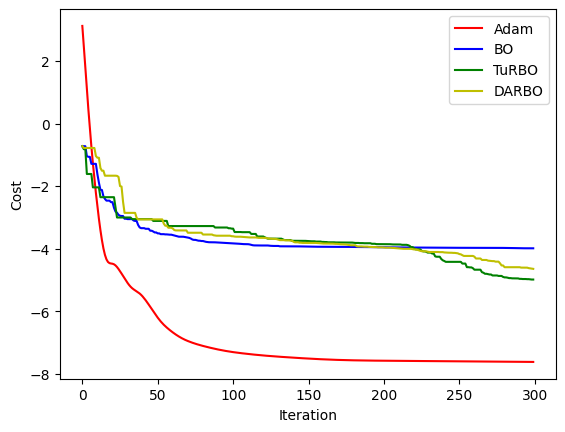

Epoch 299 min loss: -7.622221995696964	-3.989400625228882	-4.988097239723118	-4.646621564894481
Epoch 299 time: 10.246949672698975	Total time: 2632.3748412132263


In [20]:
# initial parameters
params = K.implicit_randu(shape=(2 * nlayers,))
initial_X = torch.from_numpy(np.asarray(params)).type(dtype)

# First point by BO is actually just a random selection, to have a better search, we pick the most distant point
X_new = []
for i in initial_X:
    if i <= 0.5:
        X_new.append(i + 0.5)
    else:
        X_new.append(i - 0.5)
X_new = torch.tensor(X_new)

X_bo = torch.stack((initial_X, X_new), dim=0)
Y_bo = None
X_turbo = X_bo.clone()
Y_turbo = None
X_darbo = X_bo.clone()
Y_darbo = None

losses, losses_bo, losses_turbo, losses_darbo = [], [], [], []
t0 = ts = time.time()

for i in range(300):
    loss, grads = QAOA_vag(params)
    params = opt.update(grads, params)  # gradient descent
    losses.append(loss)

    X_bo, Y_bo, _ = bo_opt.update(X_bo, Y_bo, acqfn)
    losses_bo.append(-bo_opt.best_dict["Y"].item())

    X_turbo, Y_turbo, _ = turbo_opt.update(
        X_turbo,
        Y_turbo,
        acqfn,
        transformed_input=False if i == 0 else True,
        transformed_output=True,
    )
    losses_turbo.append(-turbo_opt.best_dict["Y"].item())

    X_darbo, Y_darbo, _ = darbo_opt.update(
        X_darbo,
        Y_darbo,
        acqfn,
        transformed_input=False if i == 0 else True,
        transformed_output=True,
    )
    losses_darbo.append(-darbo_opt.best_dict["Y"].item())

    # visualise the progress
    clear_output(wait=True)
    plt.figure()
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.plot(range(i + 1), losses, c="r", label="Adam")
    plt.plot(range(i + 1), losses_bo, c="b", label="BO")
    plt.plot(range(i + 1), losses_turbo, c="g", label="TuRBO")
    plt.plot(range(i + 1), losses_darbo, c="y", label="DARBO")
    plt.legend()
    plt.show()

    print(
        f"Epoch {i} min loss: {min(losses)}\t{losses_bo[-1]}\t{losses_turbo[-1]}\t{losses_darbo[-1]}"
    )

    te = time.time()
    print(f"Epoch {i} time: {te - ts}\tTotal time: {te - t0}")
    ts = te

In [21]:
params_bo = jnp.asarray(bo_opt.best_dict["X"])
params_turbo = jnp.asarray(turbo_opt.inverse_transform(turbo_opt.best_dict["X"]))
params_darbo = jnp.asarray(
    darbo_opt.inverse_transform(
        darbo_opt.best_dict["X"], mode=darbo_opt.best_dict["mode"]
    )
)


# find the states with max probabilities
def find_max(params):
    loss = QAOA_nograd(params)
    c = QAOAansatz(params, return_circuit=True)
    probs = K.numpy(c.probability())
    max_prob = max(probs)
    index = np.where(probs == max_prob)[0]
    states = []
    for i in index:
        states.append(f"{bin(i)[2:]:0>{graph.number_of_nodes()}}")
    return loss, max_prob, states


loss, prob, states = find_max(params)
loss_bo, prob_bo, states_bo = find_max(params_bo)
loss_turbo, prob_turbo, states_turbo = find_max(params_turbo)
loss_darbo, prob_darbo, states_darbo = find_max(params_darbo)
print(f"Adam\nloss: {loss}\tprob: {prob}\tbit strings: {states}\n")
print(f"BO\nloss: {loss_bo}\tprob: {prob_bo}\tbit strings: {states_bo}\n")
print(f"TuRBO\nloss: {loss_turbo}\tprob: {prob_turbo}\tbit strings: {states_turbo}\n")
print(f"DARBO\nloss: {loss_darbo}\tprob: {prob_darbo}\tbit strings: {states_darbo}")

Adam
loss: -7.6226749521338935	prob: 0.44596658131456407	bit strings: ['10101010']

BO
loss: -3.989400528592637	prob: 0.07862131428310735	bit strings: ['10101010']

TuRBO
loss: -4.988097239723118	prob: 0.10552327846788899	bit strings: ['10101010']

DARBO
loss: -4.646621564894481	prob: 0.17829315158000258	bit strings: ['01010101', '10101010']


In [ ]:
tc.about()